In [1]:
import os 
import yaml
import tensorflow as tf 
import numpy as np

In [2]:
os.chdir('..')

from utils.VAE_utils import VAE, build_variational_encoder, build_variational_decoder

### Setup encoder & decoder configs

In [3]:
with open(os.path.join(os.getcwd(), "configs/VAE_config.yaml"), "r") as file:
    vae_config = yaml.safe_load(file)

    
encoder_config = vae_config['encoder']
decoder_config = vae_config['decoder']

### Load data - MNIST 

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
mnist_digits = np.concatenate([X_train, X_train], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

### Build encoder and decoder

In [6]:
encoder_input, encoder_output, encoder, z_mean, z_log_var = build_variational_encoder(
    encoder_config=encoder_config,
)

In [7]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mnist_inputs (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 32)   320         mnist_inputs[0][0]               
__________________________________________________________________________________________________
batch_norm_1 (BatchNormalizatio (None, 14, 14, 32)   128         encoder_conv_1[0][0]             
__________________________________________________________________________________________________
leaky_relu_encoder_1 (LeakyReLU (None, 14, 14, 32)   0           batch_norm_1[0][0]               
____________________________________________________________________________________________

In [8]:
decoder_input, decoder_output, decoder = build_variational_decoder(
    decoder_config=decoder_config
)

In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
shape_prod (Dense)           (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 14, 14, 64)        36928     
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_conv_3 (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

### Instantiate VAE class

In [10]:
variational_autoencoder = VAE(encoder, decoder)
variational_autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam()
)

variational_autoencoder.fit(
    mnist_digits, 
    epochs=10, 
    batch_size=128
)

Epoch 1/10
938/938 [==============================] - 77s 82ms/step - loss: 218.7119 - reconstruction_loss: 179.5764 - kl_loss: 1.3421
Epoch 2/10
938/938 [==============================] - 75s 80ms/step - loss: 156.7826 - reconstruction_loss: 153.9471 - kl_loss: 1.3744
Epoch 3/10
938/938 [==============================] - 75s 80ms/step - loss: 151.8740 - reconstruction_loss: 149.7424 - kl_loss: 1.5959
Epoch 4/10
938/938 [==============================] - 75s 80ms/step - loss: 149.7730 - reconstruction_loss: 147.4966 - kl_loss: 1.7108
Epoch 5/10
938/938 [==============================] - 75s 80ms/step - loss: 147.9860 - reconstruction_loss: 146.1139 - kl_loss: 1.7923
Epoch 6/10
938/938 [==============================] - 77s 82ms/step - loss: 147.3861 - reconstruction_loss: 145.1011 - kl_loss: 1.8621
Epoch 7/10
938/938 [==============================] - 76s 81ms/step - loss: 146.5136 - reconstruction_loss: 144.1767 - kl_loss: 1.9119
Epoch 8/10
938/938 [==============================] - 8

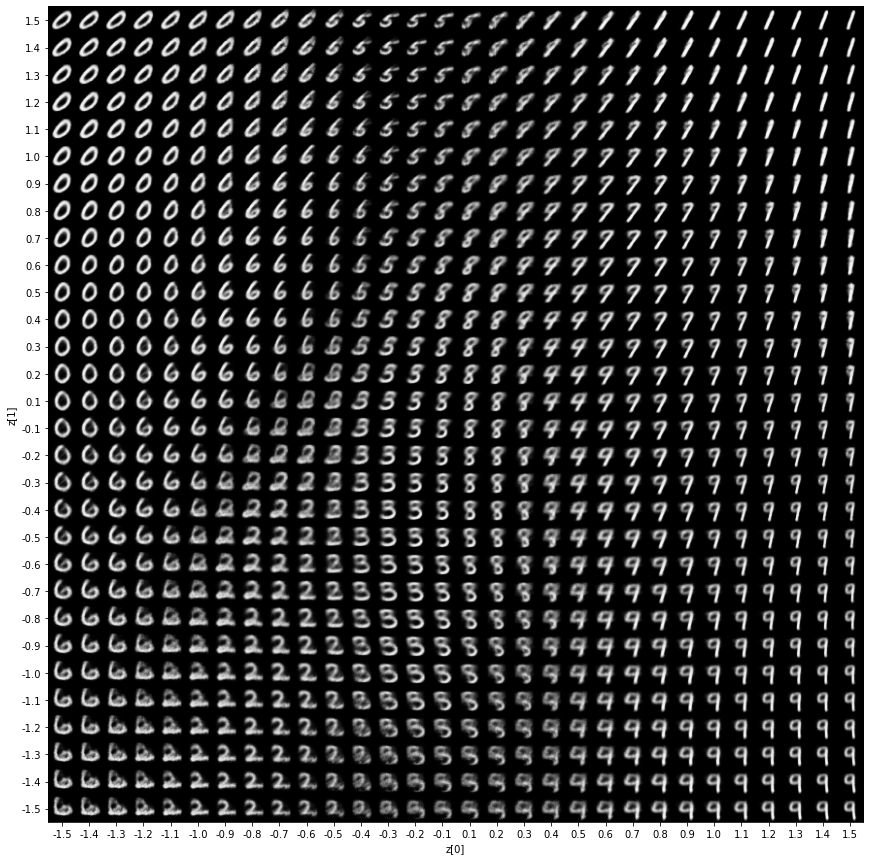

In [11]:
import matplotlib.pyplot as plt


def plot_latent_space(decoder, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.5
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(decoder)